# Matrix Fatorization

In [673]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1141589146302800608
 xla_global_id: -1]

In [674]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.optimizers import Adam
from keras.models import Model

### Hit Rate 계산 함수

일반적인 hit_rate 계산과는 다르게 User의 평가가 3.5이상인 Item만 Hit 판단

In [675]:
def calc_hit(model, u_id_list, data_df, top_n):
    hit_list = []
    u_id_list = np.asarray(u_id_list)
    for u_id in u_id_list:
        hit_count = 0
        p_id_list = np.asarray(list(set(data_df['p_id'][data_df['u_id']==u_id])))
        pred_df = pd.DataFrame(columns=['u_id', 'p_id', 'score'])
        for p_id in p_id_list:
            pred = model.predict([u_id, p_id])
            new_data = pd.DataFrame({'u_id': [u_id], 'p_id': [p_id], 'score': [pred]})
            pred_df = pd.concat([pred_df, new_data], axis=0, names=['u_id', 'p_id', 'rating'], ignore_index=True)
            recom_df = pred_df.sort_values(by=['score'], ascending=False)[:top_n]
            actual_df = data_df[data_df.u_id == u_id].sort_values(by=['score'], ascending=False)
            actual_df = actual_df[actual_df.score>=3.5][:top_n]
            
            
        for item in set(recom_df['p_id']):
            if int(item) in list(set(actual_df['p_id'])):
                hit_count += 1
                    
        hit_list.append(hit_count/top_n)
    return sum(hit_list)/len(u_id_list)

### 데이터 테이블 생성

In [676]:
table_df = pd.read_csv('../../data/ulsan_attraction_table.csv')
table_df

,place_id,u_id,user_id,score,comment,p_id
0,가지산 입석대,0,김호영(황소바위),5,NaN,248
1,가지산 입석대,1,기회란,4,NaN,248
2,가지산 입석대,2,손영진(산동무),5,NaN,248
3,가지산,0,김호영(황소바위),5,NaN,16
4,가지산,3,여름햇살,5,계단과 가파른 길이 많아 힘은 들지만 정상에서 바라보는 영남알프스의 풍경 값으로는 ...,16
...,...,...,...,...,...,...
15400,해파랑길 4코스,8870,👏👏👏,5,중간중간 길 표시가 잘안되어있어요ㅠㅠ 동해 해안가 따라 걷는 길 좋아요,130
15401,해파랑길 7코스,8877,김봉수,3,"해파랑길7코스, 상행길의 마지막부분인 아신길 코스가 있다. 아산길은 자전거길과 도보...",124
15402,해파랑길 8코스,8877,김봉수,5,울산지역 해파랑길 코스중 가장 좋은 코스입니다. 특히 염포산의 벗꽃은 정말 매력적입...,156
15403,해파랑길 9코스,8877,김봉수,4,현대중공업 인근의 도심과 봉대산을 거쳐 해안가를 걷는 코스입니다. 울산지역은 이정표...,199


In [677]:
print(table_df.isnull().sum())
table_df.drop(columns='comment', inplace=True)
table_df.dropna(axis=0, how='any', inplace=True)

place_id       0
u_id           0
user_id        0
score          0
comment     4857
p_id           0
dtype: int64


In [678]:
table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15405 entries, 0 to 15404
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   place_id  15405 non-null  object
 1   u_id      15405 non-null  int64 
 2   user_id   15405 non-null  object
 3   score     15405 non-null  int64 
 4   p_id      15405 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 601.9+ KB


In [679]:
data_df = table_df[['u_id', 'p_id', 'score']]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15405 entries, 0 to 15404
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   u_id    15405 non-null  int64
 1   p_id    15405 non-null  int64
 2   score   15405 non-null  int64
dtypes: int64(3)
memory usage: 361.2 KB


### Train, Test split

In [680]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_df, test_size=0.2, random_state=42)

In [681]:
n_users = data_df.u_id.unique().shape[0]
n_places = data_df.p_id.unique().shape[0]
print(n_users, n_places)

9153 274


In [682]:
n_users = data_df.u_id.max()
n_places = data_df.p_id.max()
print(n_users, n_places)

9152 494


In [683]:
tf.keras.backend.clear_session()

### callback

In [684]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

### Model

In [685]:
latent_dim = 80 ## 잠재요인

# creating book embedding path
place_input = Input(shape=[1], name="Place-Input")
place_embedding = Embedding(n_places+1, latent_dim, name="Place-Embedding")(place_input)
place_vec = Flatten(name="Flatten-Places")(place_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1,latent_dim, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([place_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(256, activation='relu')(conc)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = Dense(128, activation='relu')(fc2)
out = Dense(1)(fc3)

# Create model and compile it
model = Model([user_input, place_input], out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error')

In [686]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Place-Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Place-Embedding (Embedding)    (None, 1, 80)        39600       ['Place-Input[0][0]']            
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 80)        732240      ['User-Input[0][0]']             
                                                                                              

### Model Trainning

In [687]:
history = model.fit(x=[np.array(train.u_id), np.array(train.p_id)],y= np.array(train.score), validation_split=0.2, epochs=100, verbose=1, callbacks=[earlystopping])

Epoch 1/100
309/309 [==============================] - 6s 16ms/step - loss: 1.3538 - val_loss: 0.9319
Epoch 2/100
309/309 [==============================] - 4s 14ms/step - loss: 0.5575 - val_loss: 0.9971
Epoch 3/100
309/309 [==============================] - 4s 14ms/step - loss: 0.3296 - val_loss: 0.9015
Epoch 4/100
309/309 [==============================] - 5s 15ms/step - loss: 0.2187 - val_loss: 0.9023
Epoch 5/100
309/309 [==============================] - 5s 15ms/step - loss: 0.1696 - val_loss: 0.9190
Epoch 6/100
309/309 [==============================] - 5s 18ms/step - loss: 0.1397 - val_loss: 0.9382
Epoch 7/100
309/309 [==============================] - 6s 21ms/step - loss: 0.1157 - val_loss: 0.9475
Epoch 8/100
309/309 [==============================] - 10s 32ms/step - loss: 0.0972 - val_loss: 0.9026
Epoch 9/100
309/309 [==============================] - 10s 31ms/step - loss: 0.0838 - val_loss: 0.9274
Epoch 10/100
309/309 [==============================] - 9s 31ms/step - loss: 0.0

### Loss graph

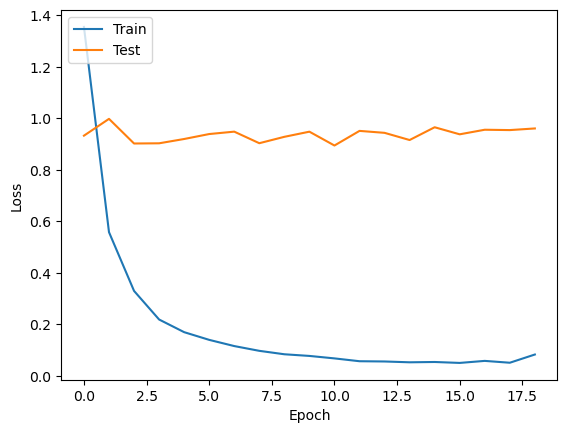

In [688]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.show()

In [689]:
model.evaluate([test.u_id, test.p_id], test.score)

97/97 [==============================] - 1s 8ms/step - loss: 0.8993


0.8993014693260193

### 성능평가(RMSE)

In [690]:
from sklearn.metrics import mean_squared_error
y_prob = model.predict([test.u_id, test.p_id])
y_true = test.score
mean_squared_error(y_true, np.round(y_prob))**0.5

97/97 [==============================] - 1s 8ms/step


0.987589329728427

In [691]:
model.save("../model/attraction_MF.h5")

### Hit Rate(적중률) 평가

In [692]:
loaded_model = tf.keras.models.load_model("../model/attraction_MF.h5")

In [693]:
uid_list = [1137, 56, 1596, 892, 1146, 836, 1198, 455, 8, 37]
uid_list = np.array(uid_list)

In [694]:
def calc_hit(model, uid_list, data_df, top_n):
    hit = []
    # pid_list = np.array(data_df.p_id.unique())
    for u_id in uid_list:
        p_id_list = np.array(list(set(data_df['p_id'][data_df['u_id']==u_id])))
        pred_df = pd.DataFrame(columns=['u_id', 'p_id', 'score'])
        for p_id in p_id_list:
            pred = model.predict([np.array([u_id]), np.array([p_id])])
            new_data = pd.DataFrame({'u_id': [u_id], 'p_id': [p_id], 'score': [pred]})
            pred_df = pd.concat([pred_df, new_data], axis=0, names=['u_id', 'p_id', 'rating'], ignore_index=True)
            recom_df = pred_df.sort_values(by=['score'], ascending=False)[:top_n]
            actual_df = data_df[data_df.u_id == u_id].sort_values(by=['score'], ascending=False)
            actual_df = actual_df[actual_df.score>=3][:top_n]
            
        for item in set(recom_df['p_id']):
            if int(item) in list(set(actual_df['p_id'])):
                hit.append(1)
            else:
                hit.append(0)
    return np.mean(hit)

In [695]:
hit_rate = calc_hit(loaded_model, uid_list, data_df, 10)

1/1 [==============================] - 0s 69ms/step


In [696]:
print('hit rate:', hit_rate)

hit rate: 0.8


In [697]:
hit_rate = calc_hit(loaded_model, uid_list, data_df, 15)

1/1 [==============================] - 0s 81ms/step


In [698]:
print('hit rate:', hit_rate)

hit rate: 0.9856115107913669


In [699]:
hit_rate = calc_hit(loaded_model, uid_list, data_df, 20)

1/1 [==============================] - 0s 24ms/step


In [700]:
print('hit rate:', hit_rate)

hit rate: 0.9856115107913669
